<a href="https://colab.research.google.com/github/marcelo-it/fraudes-financeiras-isolation-forest/blob/main/fraudes_financeiras_isolation_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Conjunto de Dados**

In [456]:
# Importando bibliotecas necess√°rias
import pandas as pd
import numpy as np
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns


In [457]:
data = pd.read_csv('/content/drive/MyDrive/fraudes-financeiras-isolation-forest/dataset-original.csv');

In [458]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393986 entries, 0 to 393985
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ID_CLIENTE                    393986 non-null  int64  
 1   MONTH                         393986 non-null  int64  
 2   CLASSIFICACAO                 393986 non-null  object 
 3   RAZAO_SOCIAL                  393986 non-null  object 
 4   CNAE                          393986 non-null  object 
 5   STATUS                        393986 non-null  object 
 6   DT_CADASTRO                   390874 non-null  object 
 7   DT_FUNDACAO                   393986 non-null  object 
 8   ENDERECO                      393985 non-null  object 
 9   BAIRRO                        393985 non-null  object 
 10  CIDADE                        393985 non-null  object 
 11  UF                            393985 non-null  object 
 12  CEP                           385679 non-nul

In [459]:
#Ajustando nomes das vari√°veis
data = data.rename(columns={'ID_CLIENTE': 'CNPJ'})
data = data.rename(columns={'CLASSIFICACAO': 'RATING'})
data = data.rename(columns={'MONTH': 'DT_INFORMACAO'})
data = data.rename(columns={'DATA_ULTIMA_COMPRA': 'DT_ULTIMA_COMPRA2'})
data = data.rename(columns={'DT_CADASTRO': 'DT_CADASTRO2'})
data = data.rename(columns={'DT_FUNDACAO': 'DT_FUNDACAO2'})

In [460]:
data.head(5)

CNPJ    DT_INFORMACAO RATING RAZAO_SOCIAL        CNAE   STATUS DT_CADASTRO2 DT_FUNDACAO2 ENDERECO                      BAIRRO             CIDADE               UF   CEP         QTD_CONSULTAS  MAIOR_ACUMULO  QTD_ASSOCIADAS_MAIOR_ACUMULO  DEBITO_ATUAL  QTD_ASSOCIADAS_DEBITO_ATUAL DT_ULTIMA_COMPRA2
0  382108  2              D      BANCO DO BRASIL SA  203-8  ATIVA  1999-01-19   1991-04-25   AV CEL JOSE SOARES MARCONDES  JARDIM BONGIOVANI  PRESIDENTE PRUDENTE  SP  19050230.0  4.0            50919498.38    12.0                          23781257.23    7.0                         2025-02-27      
1  382108  3              C      BANCO DO BRASIL SA  203-8  ATIVA  1999-01-19   1991-04-25   AV CEL JOSE SOARES MARCONDES  JARDIM BONGIOVANI  PRESIDENTE PRUDENTE  SP  19050230.0  1.0            50919088.96    11.0                          24708162.77    6.0                         2025-03-27      
2  382108  5              D      BANCO DO BRASIL SA   2038  ATIVA  1999-01-19   1991-04-25   AV CEL JOSE SOARES MARCONDES  JARDIM BONGIOVANI  PRESIDENTE PRUDENTE  SP  19050230.0  1.0            75110064.88    13.0                          37793130.22   10.0                         2024-05-28      
3  382108  6              C      BANCO DO BRASIL SA   2038  ATIVA  1999-01-19   1991-04-25   AV CEL JOSE SOARES MARCONDES  JARDIM BONGIOVANI  PRESIDENTE PRUDENTE  SP  19050230.0  1.0            60779630.00    11.0                          32958037.23    8.0                         2024-06-26      
4  382108  7              C      BANCO DO BRASIL SA   2038  ATIVA  1999-01-19   1991-04-25   AV CEL JOSE SOARES MARCONDES  JARDIM BONGIOVANI  PRESIDENTE PRUDENTE  SP  19050230.0  3.0            52137216.34    11.0                          25177567.24    7.0                         2024-07-29

In [461]:
# Converte os nomes das colunas para letras min√∫sculas
data.columns = data.columns.str.lower()

In [462]:
# Aplicar strip() e lower() em todas as colunas de texto
data = data.apply(lambda col: col.str.strip().str.lower() if col.dtype == "object" else col)
data.head(5)

cnpj    dt_informacao rating razao_social        cnae   status dt_cadastro2 dt_fundacao2 endereco                      bairro             cidade               uf   cep         qtd_consultas  maior_acumulo  qtd_associadas_maior_acumulo  debito_atual  qtd_associadas_debito_atual dt_ultima_compra2
0  382108  2              d      banco do brasil sa  203-8  ativa  1999-01-19   1991-04-25   av cel jose soares marcondes  jardim bongiovani  presidente prudente  sp  19050230.0  4.0            50919498.38    12.0                          23781257.23    7.0                         2025-02-27      
1  382108  3              c      banco do brasil sa  203-8  ativa  1999-01-19   1991-04-25   av cel jose soares marcondes  jardim bongiovani  presidente prudente  sp  19050230.0  1.0            50919088.96    11.0                          24708162.77    6.0                         2025-03-27      
2  382108  5              d      banco do brasil sa   2038  ativa  1999-01-19   1991-04-25   av cel jose soares marcondes  jardim bongiovani  presidente prudente  sp  19050230.0  1.0            75110064.88    13.0                          37793130.22   10.0                         2024-05-28      
3  382108  6              c      banco do brasil sa   2038  ativa  1999-01-19   1991-04-25   av cel jose soares marcondes  jardim bongiovani  presidente prudente  sp  19050230.0  1.0            60779630.00    11.0                          32958037.23    8.0                         2024-06-26      
4  382108  7              c      banco do brasil sa   2038  ativa  1999-01-19   1991-04-25   av cel jose soares marcondes  jardim bongiovani  presidente prudente  sp  19050230.0  3.0            52137216.34    11.0                          25177567.24    7.0                         2024-07-29

In [463]:
# Renomear e converter datas
data = data.rename(columns={'cnpj': 'customerID'})

data = data.rename(columns={'dt_informacao': 'updated'})

data = data.rename(columns={'razao_social': 'name'})

data = data.rename(columns={'endereco': 'address'})

data = data.rename(columns={'bairro': 'neighborhood'})

data = data.rename(columns={'cidade': 'city'})

data = data.rename(columns={'uf': 'state'})

data = data.rename(columns={'cep': 'zipCode'})

data = data.rename(columns={'qtd_consultas': 'queries'})

# Convert 'DT_FUNDACAO' to datetime objects, handling errors
data['dt_fundacao2'] = pd.to_datetime(data['dt_fundacao2'], errors='coerce').dt.normalize()
data = data.rename(columns={'dt_fundacao2': 'foundation'})

# Convert 'DT_CADASTRO' to datetime objects, handling errors
data['dt_cadastro2'] = pd.to_datetime(data['dt_cadastro2'], errors='coerce').dt.normalize()
data = data.rename(columns={'dt_cadastro2': 'registration'})

# Convert 'DATA_ULTIMA_COMPRA' to datetime objects, handling errors
data['dt_ultima_compra2'] = pd.to_datetime(data['dt_ultima_compra2'], errors='coerce').dt.normalize()
data = data.rename(columns={'dt_ultima_compra2': 'lastPurchase'})


In [464]:
# Renomeando a coluna 'maior_acumulo'
data = data.rename(columns={'maior_acumulo': 'amountGreaterAccumulation'})

# Substituindo valores ausentes por 0.00 na coluna 'maior_acumulo'
data['amountGreaterAccumulation'] = data['amountGreaterAccumulation'].fillna(0.0)



# Renomeando a coluna 'qtd_associadas_maior_acumulo'
data = data.rename(columns={'qtd_associadas_maior_acumulo': 'quantityGreaterAccumulation'})

# Substituir NaN por 0 e converter para inteiro para a coluna 'qtd_associadas_maior_acumulo'
data['quantityGreaterAccumulation'] = data['quantityGreaterAccumulation'].fillna(0.0).astype(int)



# Renomeando a coluna 'debito_atual'
data = data.rename(columns={'debito_atual': 'amountDebit'})

# Substituir NaN por 0 e converter para inteiro para a coluna 'debito_atual'
data['amountDebit'] = data['amountDebit'].fillna(0.0).astype(int)



# Renomeando a coluna 'qtd_associadas_debito_atual'
data = data.rename(columns={'qtd_associadas_debito_atual': 'quantityDebit'})

# Substituir NaN por 0 e converter para inteiro para a coluna 'qtd_associadas_debito_atual'
data['quantityDebit'] = data['quantityDebit'].fillna(0.0).astype(int)




In [465]:
data.head(5)

customerID  updated rating name                cnae   status registration foundation address                       neighborhood       city                 state  zipCode     queries  amountGreaterAccumulation  quantityGreaterAccumulation  amountDebit  quantityDebit lastPurchase
0  382108      2        d      banco do brasil sa  203-8  ativa 1999-01-19   1991-04-25  av cel jose soares marcondes  jardim bongiovani  presidente prudente  sp    19050230.0  4.0      50919498.38                12                           23781257      7            2025-02-27  
1  382108      3        c      banco do brasil sa  203-8  ativa 1999-01-19   1991-04-25  av cel jose soares marcondes  jardim bongiovani  presidente prudente  sp    19050230.0  1.0      50919088.96                11                           24708162      6            2025-03-27  
2  382108      5        d      banco do brasil sa   2038  ativa 1999-01-19   1991-04-25  av cel jose soares marcondes  jardim bongiovani  presidente prudente  sp    19050230.0  1.0      75110064.88                13                           37793130     10            2024-05-28  
3  382108      6        c      banco do brasil sa   2038  ativa 1999-01-19   1991-04-25  av cel jose soares marcondes  jardim bongiovani  presidente prudente  sp    19050230.0  1.0      60779630.00                11                           32958037      8            2024-06-26  
4  382108      7        c      banco do brasil sa   2038  ativa 1999-01-19   1991-04-25  av cel jose soares marcondes  jardim bongiovani  presidente prudente  sp    19050230.0  3.0      52137216.34                11                           25177567      7            2024-07-29

In [466]:
import pandas as pd

# Dados do dicion√°rio
data_dict = {
    "Nome da Vari√°vel": [
           "customerID", "updated", "rating", "name", "cnae", "status", "registration", "foundation","address", "neighborhood","city","state", "zipCode","queries",
           "amountGreaterAccumulation","quantityGreaterAccumulation","amountDebit", "quantityDebit","lastPurchase"],
    "Tipo de Dados": [
        "String", "Date", "String", "String", "String", "String", "Date", "Date",
        "String", "String", "String", "String", "Int", "Int", "Float", "Int", "Float", "Int", "Date"],
    "Descri√ß√£o": [
        "CNPJ Identifica√ß√£o √∫nica da empresa (Cadastro Nacional da Pessoa Jur√≠dica)",
        "Data da informa√ß√£o (M√™s e Ano)  formato YYYY-MM",
        "Classifica√ß√£o do risco de performance empresa (score de cr√©dito)",
        "Nome oficial da empresa",
        "CNAE (C√≥digo da Atividade Econ√¥mica Principal da Empresa)",
        "Situa√ß√£o cadastral da empresa junto a Receita Federal do Brasil",
        "Data de cadastro da empresa na CISP",
        "Data de Funda√ß√£o da empresa",
        "Endere√ßo da empresa",
        "Bairro da empresa",
        "Cidade da empresa",
        "Estado da empresa (Unidade Federativa)",
        "CEP da empresa",
        "Quantidade de consultas realizadas pelos associados para o CNPJ",
        "Valor do Maior Ac√∫mulo (Valor consolidado contendo todos associados)",
        "Quantidade de associadas que comp√µem o Valor o Maior Ac√∫mulo",
        "Valor do D√©bito Total (Valor consolidado contendo todos associados)",
        "Quantidade de associadas que comp√µem o D√©bito Total",
        "Data da √öltima Compra (mais recente)"

    ],
    "Exemplo de Valor": [
        "43454446000107", "2025-05", "A", "CISP Central de Informa√ß√µes S√£o Paulo",  "94.11-1-00", "ATIVA", "1972-11-30", "2000-01-15",
        "R DO BOSQUE 1589 ANEXO II ANDAR 15", "BARRA FUNDA", "SAO PAULO", "SP",
        "01136001", "33", "500000.00", "10", "300000.00", "5", "2024-12-30"
    ]
}

# Criando o DataFrame
data_dict_df = pd.DataFrame(data_dict)

# Salvando como tabela para inclus√£o na tese
data_dict_df.to_csv("/content/drive/MyDrive/fraudes-financeiras-isolation-forest/dicionario-de-dados.csv", index=False)

# Gerando o LaTeX
latex_output = data_dict_df.to_latex(index=False, longtable=True)

# Salvando o LaTeX em um arquivo
with open("dicionario_de_dados.tex", "w") as f:
    f.write(latex_output)

# Configura√ß√µes de exibi√ß√£o
pd.set_option('display.max_rows', 100)       # Exibe at√© 100 linhas
pd.set_option('display.max_columns', 50)    # Exibe at√© 50 colunas
pd.set_option('display.width', 10000)        # Ajusta a largura para n√£o cortar
pd.set_option('display.colheader_justify', 'left')  # Justifica os nomes das colunas


# Exibindo o DataFrame
print(data_dict_df)

# Exibindo o c√≥digo LaTeX
print(latex_output)


   Nome da Vari√°vel             Tipo de Dados Descri√ß√£o                                          Exemplo de Valor                      
0                    customerID  String        CNPJ Identifica√ß√£o √∫nica da empresa (Cadastro ...                         43454446000107
1                       updated    Date          Data da informa√ß√£o (M√™s e Ano)  formato YYYY-MM                                2025-05
2                        rating  String        Classifica√ß√£o do risco de performance empresa ...                                      A
3                          name  String                                  Nome oficial da empresa  CISP Central de Informa√ß√µes S√£o Paulo
4                          cnae  String        CNAE (C√≥digo da Atividade Econ√¥mica Principal ...                             94.11-1-00
5                        status  String        Situa√ß√£o cadastral da empresa junto a Receita ...                                  ATIVA
6                  registratio

In [467]:
data.shape

(393986, 19)

In [468]:
# Contando valores nulos em todas as colunas
data.isnull().sum()

customerID                        0
updated                           0
rating                            0
name                              0
cnae                              0
status                            0
registration                   3112
foundation                        1
address                           1
neighborhood                      1
city                              1
state                             1
zipCode                        8307
queries                           1
amountGreaterAccumulation         0
quantityGreaterAccumulation       0
amountDebit                       0
quantityDebit                     0
lastPurchase                   5339
dtype: int64

In [469]:
data.shape


(393986, 19)

In [470]:
duplicateRows = data[data.duplicated()]
duplicateRows

Empty DataFrame
Columns: [customerID, updated, rating, name, cnae, status, registration, foundation, address, neighborhood, city, state, zipCode, queries, amountGreaterAccumulation, quantityGreaterAccumulation, amountDebit, quantityDebit, lastPurchase]
Index: []

In [471]:
# Conta quantos valores √∫nicos existem na coluna 'customerID'
quantidade_unicos = data['customerID'].nunique()

print(f'N√∫mero de registros √∫nicos: {quantidade_unicos}')

N√∫mero de registros √∫nicos: 100929


In [472]:
# Contando valores NaN em todas as colunas
nan_por_coluna = data.isna().sum()

print(nan_por_coluna)

customerID                        0
updated                           0
rating                            0
name                              0
cnae                              0
status                            0
registration                   3112
foundation                        1
address                           1
neighborhood                      1
city                              1
state                             1
zipCode                        8307
queries                           1
amountGreaterAccumulation         0
quantityGreaterAccumulation       0
amountDebit                       0
quantityDebit                     0
lastPurchase                   5339
dtype: int64


In [473]:
# Remover registros onde a coluna 'status' √© nula (NaN) ou em branco
data = data[data['status'].notna() & (data['status'].str.strip() != '')]

In [474]:
unique_status = data['status'].unique()
print("Valores √∫nicos na coluna 'status':")
print(unique_status)

Valores √∫nicos na coluna 'status':
['ativa' 'baixada' 'inapta' 'suspensa']


In [475]:
status_counts = data['status'].value_counts()
print("Contagem de cada valor na coluna 'status':")
print(status_counts)

Contagem de cada valor na coluna 'status':
status
ativa       385653
baixada       5678
inapta        2414
suspensa       241
Name: count, dtype: int64


In [476]:
# Criar a nova coluna com a l√≥gica desejada
status_positivos = ['ativo', 'ativa']
status_negativos = ['baixado', 'inapto', 'suspenso', 'nula', 'inapta']


In [477]:
data['statusActive'] = data['status'].apply(
    lambda x: True if x in status_positivos else False if x in status_negativos else None
)

# Verificar os valores √∫nicos na nova coluna
print("Valores √∫nicos em 'statusActive':")
print(data['statusActive'].value_counts())

Valores √∫nicos em 'statusActive':
statusActive
True     385653
False      2414
Name: count, dtype: int64


In [478]:
data.drop('status', axis=1, inplace=True)

In [479]:
print(data['statusActive'].value_counts(dropna=True))

statusActive
True     385653
False      2414
Name: count, dtype: int64


In [480]:
# Remover registros onde 'cnae' √© NaN
data = data.dropna(subset=['cnae'])

In [481]:
# Remover registros onde 'foundation_date' √© NaN
data = data.dropna(subset=['foundation'])

In [482]:
# Contando valores NaN em todas as colunas
nan_por_coluna = data.isna().sum()

print(nan_por_coluna)

customerID                        0
updated                           0
rating                            0
name                              0
cnae                              0
registration                   3112
foundation                        0
address                           0
neighborhood                      0
city                              0
state                             0
zipCode                        8306
queries                           0
amountGreaterAccumulation         0
quantityGreaterAccumulation       0
amountDebit                       0
quantityDebit                     0
lastPurchase                   5338
statusActive                   5919
dtype: int64


In [483]:
# Ordenar os dados
data = data.sort_values(by=['customerID', 'updated'], ascending=[True, True])

# Lista de colunas pertencetes ao endere√ßo a serem verificadas
colunas_para_verificar = ['address', 'neighborhood', 'city', 'state', 'zipCode']

# Verificar se houve altera√ß√£o em qualquer coluna do endere√ßo
data['addressChanged'] = (
    data.groupby('customerID')[colunas_para_verificar]
    .apply(lambda group: group.ne(group.shift()).any(axis=1))
    .reset_index(drop=True)
)

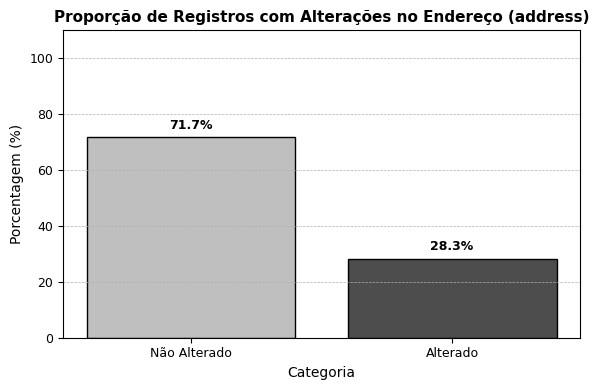

In [484]:
import pandas as pd
import matplotlib.pyplot as plt

# Contagem dos valores em 'addressChanged' com porcentagem
value_counts = data['addressChanged'].value_counts(normalize=True) * 100

# Tons recomendados: cinza escuro para True, cinza claro para False
gray_colors = ['#4d4d4d' if value else '#bfbfbf' for value in value_counts.index]

# Criar novo gr√°fico com tons de cinza
plt.figure(figsize=(6, 4))

bars = plt.bar(
    value_counts.index.map({True: 'Alterado', False: 'N√£o Alterado'}),
    value_counts.values,
    color=gray_colors,
    edgecolor='black'
)

# Inserindo os valores de porcentagem acima das barras
for i, value in enumerate(value_counts.values):
    plt.text(i, value + 2, f'{value:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Configura√ß√µes visuais IEEE
plt.title('Propor√ß√£o de Registros com Altera√ß√µes no Endere√ßo (address)', fontsize=11, fontweight='bold')
plt.ylabel('Porcentagem (%)', fontsize=10)
plt.xlabel('Categoria', fontsize=10)
plt.ylim(0, 110)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Salvar o gr√°fico em tons de cinza
output_gray_path = "/content/drive/MyDrive/fraudes-financeiras-isolation-forest/grafico_addressChanged_IEEE_tons_de_cinza.png"
plt.savefig(output_gray_path, dpi=600)
plt.show()
plt.close()


In [485]:
# Deletar as colunas originais
data = data.drop(columns=colunas_para_verificar)

In [486]:
# Ordenar os dados
data = data.sort_values(by=['customerID', 'updated'], ascending=[True, True])

# Detectar mudan√ßas na coluna cnae para cada customerID
data['cnaeChanged'] = (
    (data['cnae'] != data['cnae'].shift()) &  # Detecta mudan√ßas na coluna cnae
    (data['customerID'] == data['customerID'].shift())  # Garante que seja dentro do mesmo customerID
)


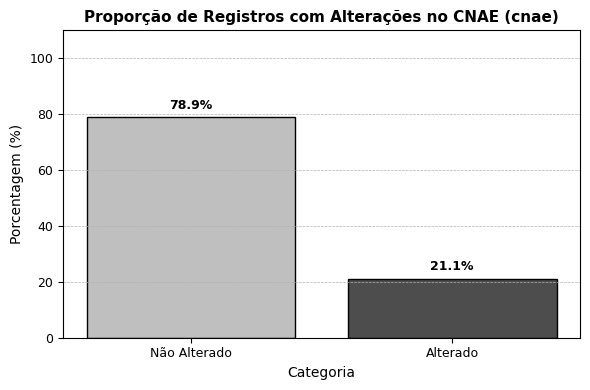

In [487]:
import pandas as pd
import matplotlib.pyplot as plt


# Contagem dos valores em 'addressChanged' com porcentagem
value_counts = data['cnaeChanged'].value_counts(normalize=True) * 100

# Tons recomendados: cinza escuro para True, cinza claro para False
gray_colors = ['#4d4d4d' if value else '#bfbfbf' for value in value_counts.index]

# Criar novo gr√°fico com tons de cinza
plt.figure(figsize=(6, 4))

bars = plt.bar(
    value_counts.index.map({True: 'Alterado', False: 'N√£o Alterado'}),
    value_counts.values,
    color=gray_colors,
    edgecolor='black'
)

# Inserindo os valores de porcentagem acima das barras
for i, value in enumerate(value_counts.values):
    plt.text(i, value + 2, f'{value:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Configura√ß√µes visuais IEEE
plt.title('Propor√ß√£o de Registros com Altera√ß√µes no CNAE (cnae)', fontsize=11, fontweight='bold')
plt.ylabel('Porcentagem (%)', fontsize=10)
plt.xlabel('Categoria', fontsize=10)
plt.ylim(0, 110)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Salvar o gr√°fico em tons de cinza
output_gray_path = "/content/drive/MyDrive/fraudes-financeiras-isolation-forest/grafico_cnaeChanged_IEEE_tons_de_cinza.png"
plt.savefig(output_gray_path, dpi=600)
plt.show()
plt.close()


In [488]:
# Excluir a coluna cnae original, se necess√°rio
data = data.drop(columns=['cnae'])

In [489]:
# Ordenar os dados
data = data.sort_values(by=['customerID', 'updated'], ascending=[True, True])

# Detectar mudan√ßas na coluna name para cada customerID
data['nameChanged'] = (
    (data['name'] != data['name'].shift()) &  # Detecta mudan√ßas na coluna name
    (data['customerID'] == data['customerID'].shift())  # Garante que seja dentro do mesmo customerID
)


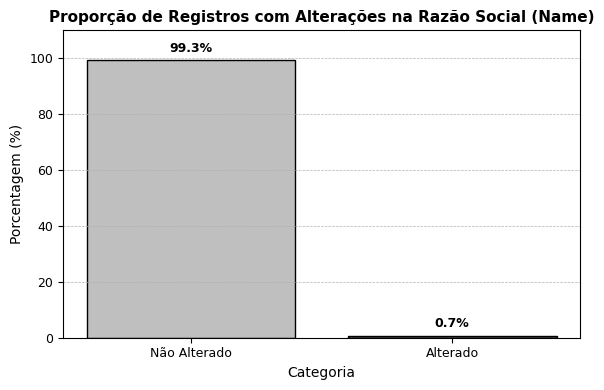

In [490]:
import pandas as pd
import matplotlib.pyplot as plt


# Contagem dos valores em 'addressChanged' com porcentagem
value_counts = data['nameChanged'].value_counts(normalize=True) * 100

# Tons recomendados: cinza escuro para True, cinza claro para False
gray_colors = ['#4d4d4d' if value else '#bfbfbf' for value in value_counts.index]

# Criar novo gr√°fico com tons de cinza
plt.figure(figsize=(6, 4))

bars = plt.bar(
    value_counts.index.map({True: 'Alterado', False: 'N√£o Alterado'}),
    value_counts.values,
    color=gray_colors,
    edgecolor='black'
)

# Inserindo os valores de porcentagem acima das barras
for i, value in enumerate(value_counts.values):
    plt.text(i, value + 2, f'{value:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Configura√ß√µes visuais IEEE
plt.title('Propor√ß√£o de Registros com Altera√ß√µes na Raz√£o Social (Name)', fontsize=11, fontweight='bold')
plt.ylabel('Porcentagem (%)', fontsize=10)
plt.xlabel('Categoria', fontsize=10)
plt.ylim(0, 110)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Salvar o gr√°fico em tons de cinza
output_gray_path = "/content/drive/MyDrive/fraudes-financeiras-isolation-forest/grafico_nameChanged_IEEE_tons_de_cinza.png"
plt.savefig(output_gray_path, dpi=600)
plt.show()
plt.close()

In [491]:
# Excluir a coluna cnae original, se necess√°rio
data = data.drop(columns=['name'])

In [492]:
data.head(5)

customerID  updated rating registration foundation  queries  amountGreaterAccumulation  quantityGreaterAccumulation  amountDebit  quantityDebit lastPurchase statusActive  addressChanged  cnaeChanged  nameChanged
0  382108      2        d     1999-01-19   1991-04-25  4.0      50919498.38                12                           23781257      7            2025-02-27    True          True           False        False      
1  382108      3        c     1999-01-19   1991-04-25  1.0      50919088.96                11                           24708162      6            2025-03-27    True         False           False        False      
2  382108      5        d     1999-01-19   1991-04-25  1.0      75110064.88                13                           37793130     10            2024-05-28    True         False            True        False      
3  382108      6        c     1999-01-19   1991-04-25  1.0      60779630.00                11                           32958037      8            2024-06-26    True         False           False        False      
4  382108      7        c     1999-01-19   1991-04-25  3.0      52137216.34                11                           25177567      7            2024-07-29    True         False           False        False

In [493]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393985 entries, 0 to 393984
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   customerID                   393985 non-null  int64         
 1   updated                      393985 non-null  int64         
 2   rating                       393985 non-null  object        
 3   registration                 390873 non-null  datetime64[ns]
 4   foundation                   393985 non-null  datetime64[ns]
 5   queries                      393985 non-null  float64       
 6   amountGreaterAccumulation    393985 non-null  float64       
 7   quantityGreaterAccumulation  393985 non-null  int64         
 8   amountDebit                  393985 non-null  int64         
 9   quantityDebit                393985 non-null  int64         
 10  lastPurchase                 388647 non-null  datetime64[ns]
 11  statusActive                 38

In [494]:
from datetime import datetime

# Converte a coluna foundationDate para o formato datetime
data['foundation'] = pd.to_datetime(data['foundation'])

# Calcula o n√∫mero de anos desde a data de funda√ß√£o
data['yearsSinceFoundation'] = datetime.now().year - data['foundation'].dt.year

# Define a fun√ß√£o para classificar o risco com base nos anos de funda√ß√£o
def classify_risk(years):
    if years < 5:
        return 'High'
    elif 5 <= years <= 15:
        return 'Medium'
    else:
        return 'Low'

# Aplica a fun√ß√£o de classifica√ß√£o
data['riskFoundation'] = data['yearsSinceFoundation'].apply(classify_risk)


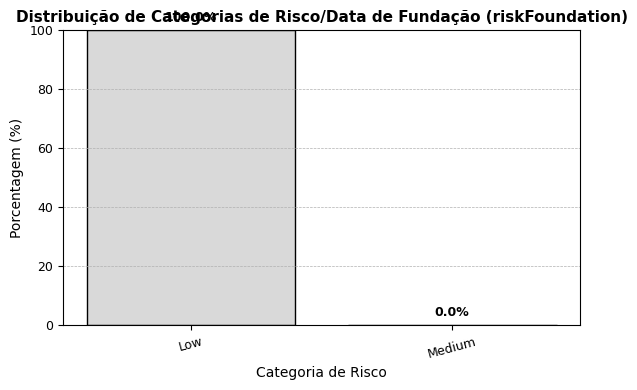

In [495]:
import matplotlib.pyplot as plt
import pandas as pd


# Calcula a distribui√ß√£o por categoria de risco em porcentagem
risk_counts_percentage = data['riskFoundation'].value_counts(normalize=True) * 100

# Definindo tons de cinza para cada categoria de risco
gray_colors = {
    'High': '#4d4d4d',    # Cinza escuro
    'Medium': '#969696',  # Cinza m√©dio
    'Low': '#d9d9d9'      # Cinza claro
}

# Criando o gr√°fico de barras
plt.figure(figsize=(6, 4))
plt.bar(
    risk_counts_percentage.index,
    risk_counts_percentage.values,
    color=[gray_colors[risk] for risk in risk_counts_percentage.index],
    edgecolor='black'
)

# Inserindo os valores de porcentagem acima das barras
for i, value in enumerate(risk_counts_percentage.values):
    plt.text(i, value + 2, f'{value:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Configura√ß√µes visuais IEEE
plt.title('Distribui√ß√£o de Categorias de Risco/Data de Funda√ß√£o (riskFoundation)', fontsize=11, fontweight='bold')
plt.ylabel('Porcentagem (%)', fontsize=10)
plt.xlabel('Categoria de Risco', fontsize=10)
plt.ylim(0, 100)
plt.xticks(rotation=15, fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Salvar o gr√°fico em tons de cinza
output_path = "/content/drive/MyDrive/fraudes-financeiras-isolation-forest/grafico_riskFoundation_IEEE_tons_de_cinza.png"
plt.savefig(output_gray_path, dpi=600)
plt.show()
plt.close()


In [496]:
# Remover a coluna yearsSinceFoundation
data = data.drop(columns=['yearsSinceFoundation'])

In [497]:
# Cria vari√°vel bin√°ria para data da fundacao recente
from datetime import datetime

data['isNewFoundation'] = data['foundation'].notna() & (
    ((datetime.now() - data['foundation']).dt.days / 365.25) < 3
)

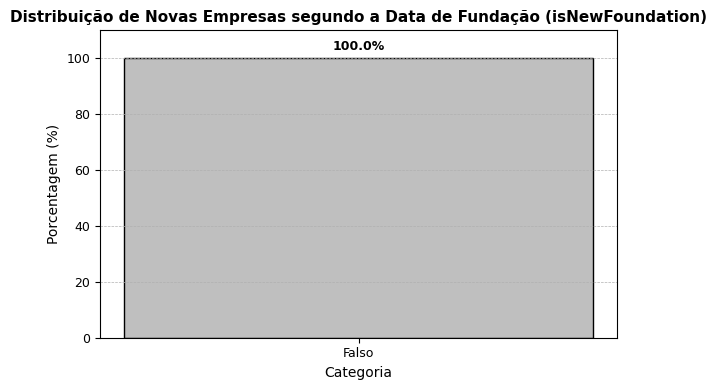

In [498]:
# Simulando dados para 'isNewFoundation'
import pandas as pd
import matplotlib.pyplot as plt


# Contagem dos valores em 'isNewFoundation' com porcentagem
value_counts = data['isNewFoundation'].value_counts(normalize=True) * 100

# Definindo cores em tons de cinza: cinza escuro para True, cinza claro para False
colors = ['#4d4d4d' if value else '#bfbfbf' for value in value_counts.index]

# Criando o gr√°fico
plt.figure(figsize=(6, 4))

plt.bar(
    value_counts.index.map({True: 'Verdadeiro', False: 'Falso'}),
    value_counts.values,
    color=colors,
    edgecolor='black'
)

# Inserindo os valores de porcentagem acima das barras
for i, value in enumerate(value_counts.values):
    plt.text(i, value + 2, f'{value:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Configura√ß√µes IEEE
plt.title('Distribui√ß√£o de Novas Empresas segundo a Data de Funda√ß√£o (isNewFoundation)', fontsize=11, fontweight='bold')
plt.ylabel('Porcentagem (%)', fontsize=10)
plt.xlabel('Categoria', fontsize=10)
plt.ylim(0, 110)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Salvar o gr√°fico
output_path = "/content/drive/MyDrive/fraudes-financeiras-isolation-forest/grafico_isNewFoundation_IEEE_tons_de_cinza.png"
plt.savefig(output_gray_path, dpi=600)
plt.show()
plt.close()


In [499]:
from datetime import datetime, timedelta

def check_alert(dataset):
    # Obtem datas de refer√™ncia
    current_date = datetime.now()
    date_minus_2_years = current_date.replace(year=current_date.year - 2)
    date_minus_4_years = current_date.replace(year=current_date.year - 4)

    # Adiciona uma nova coluna 'registrationAlert' com base na condi√ß√£o
    dataset['registrationAlert'] = (
        (pd.to_datetime(dataset['registration']) < date_minus_2_years) &
        (pd.to_datetime(dataset['foundation']) > date_minus_4_years)
    )

    return dataset

In [500]:
# Aplica a fun√ß√£o
data = check_alert(data)

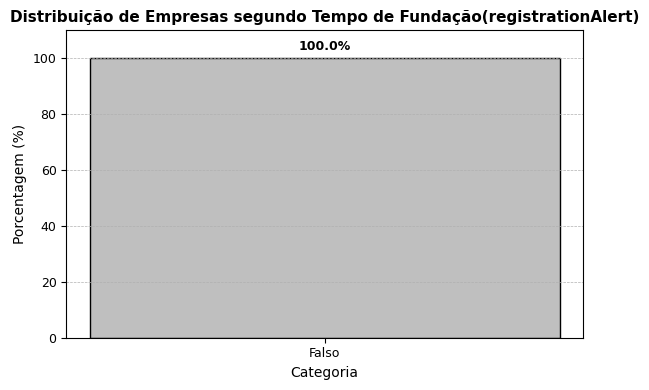

In [501]:
# Simulando dados para 'isNewFoundation'
import pandas as pd
import matplotlib.pyplot as plt


# Contagem dos valores em 'isNewFoundation' com porcentagem
value_counts = data['registrationAlert'].value_counts(normalize=True) * 100

# Definindo cores em tons de cinza: cinza escuro para True, cinza claro para False
colors = ['#4d4d4d' if value else '#bfbfbf' for value in value_counts.index]

# Criando o gr√°fico
plt.figure(figsize=(6, 4))

plt.bar(
    value_counts.index.map({True: 'Verdadeiro', False: 'Falso'}),
    value_counts.values,
    color=colors,
    edgecolor='black'
)

# Inserindo os valores de porcentagem acima das barras
for i, value in enumerate(value_counts.values):
    plt.text(i, value + 2, f'{value:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Configura√ß√µes IEEE
plt.title('Distribui√ß√£o de Empresas segundo Tempo de Funda√ß√£o(registrationAlert)', fontsize=11, fontweight='bold')
plt.ylabel('Porcentagem (%)', fontsize=10)
plt.xlabel('Categoria', fontsize=10)
plt.ylim(0, 110)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Salvar o gr√°fico
output_path = "/content/drive/MyDrive/fraudes-financeiras-isolation-forest/grafico_registrationAlert_IEEE_tons_de_cinza.png"
plt.savefig(output_gray_path, dpi=600)
plt.show()
plt.close()


In [502]:
# Remover a coluna foundationDate e registration
data = data.drop(columns=['foundation'])
data = data.drop(columns=['registration'])

**Comportamento no Volume de Consultas**

In [503]:
# Calcula a m√©dia m√≥vel de 3 meses para cada cliente
data['3_months_avg'] = (
    data.groupby('customerID')['queries']
    .apply(lambda x: x.rolling(window=3, min_periods=1).mean())
    .reset_index(level=0, drop=True)  # Reset o √≠ndice para corresponder ao DataFrame original.
)

In [504]:
# Verifica se houve um aumento de 30% em compara√ß√£o com a m√©dia m√≥vel de 3 meses
data['queriesIncreaseAlert'] = (
    (data['queries'] > 1.3 * data['3_months_avg']) &
    (data['3_months_avg'] > 0)  # Para evitar a divis√£o por zero
)

In [505]:
# Remover a coluna foundationDate e registration
data = data.drop(columns=['3_months_avg'])
data = data.drop(columns=['queries'])

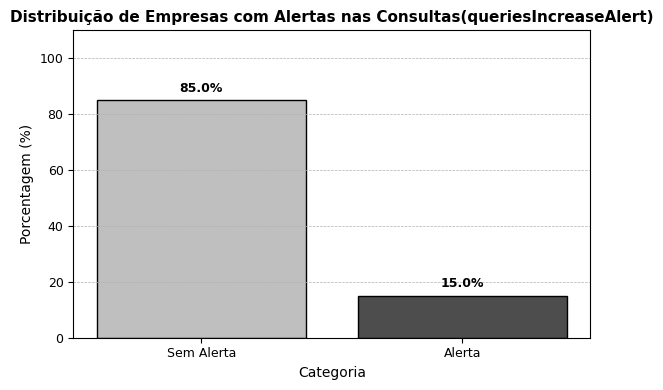

In [506]:
# Simulando dados para 'queriesIncreaseAlert'
import pandas as pd
import matplotlib.pyplot as plt


# Contagem dos valores em 'queriesIncreaseAlert' com porcentagem
value_counts = data['queriesIncreaseAlert'].value_counts(normalize=True) * 100

# Definindo cores em tons de cinza: cinza escuro para True, cinza claro para False
colors = ['#4d4d4d' if value else '#bfbfbf' for value in value_counts.index]

# Criando o gr√°fico
plt.figure(figsize=(6, 4))

plt.bar(
    value_counts.index.map({True: 'Alerta', False: 'Sem Alerta'}),
    value_counts.values,
    color=colors,
    edgecolor='black'
)

# Inserindo os valores de porcentagem acima das barras
for i, value in enumerate(value_counts.values):
    plt.text(i, value + 2, f'{value:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Configura√ß√µes IEEE
plt.title('Distribui√ß√£o de Empresas com Alertas nas Consultas(queriesIncreaseAlert)', fontsize=11, fontweight='bold')
plt.ylabel('Porcentagem (%)', fontsize=10)
plt.xlabel('Categoria', fontsize=10)
plt.ylim(0, 110)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Salvar o gr√°fico
output_path = "/content/drive/MyDrive/fraudes-financeiras-isolation-forest/grafico_registrationAlert_IEEE_tons_de_cinza.png"
plt.savefig(output_gray_path, dpi=600)
plt.show()
plt.close()


In [507]:
# Verifica se houve compra recente nos √∫ltimos 3 meses

data['lastPurchase'] = pd.to_datetime(data['lastPurchase'])

# Cria a vari√°vel booleana com base na data de corte
data['isLastPurchase'] = data['lastPurchase'] > pd.to_datetime('2025-02-28')

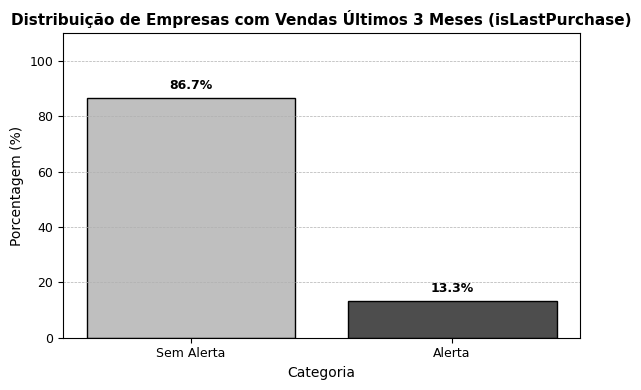

In [508]:
# Simulando dados para 'isLastPurchase'
import pandas as pd
import matplotlib.pyplot as plt


# Contagem dos valores em 'isLastPurchase' com porcentagem
value_counts = data['isLastPurchase'].value_counts(normalize=True) * 100

# Definindo cores em tons de cinza: cinza escuro para True, cinza claro para False
colors = ['#4d4d4d' if value else '#bfbfbf' for value in value_counts.index]

# Criando o gr√°fico
plt.figure(figsize=(6, 4))

plt.bar(
    value_counts.index.map({True: 'Alerta', False: 'Sem Alerta'}),
    value_counts.values,
    color=colors,
    edgecolor='black'
)

# Inserindo os valores de porcentagem acima das barras
for i, value in enumerate(value_counts.values):
    plt.text(i, value + 2, f'{value:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Configura√ß√µes IEEE
plt.title('Distribui√ß√£o de Empresas com Vendas √öltimos 3 Meses (isLastPurchase)', fontsize=11, fontweight='bold')
plt.ylabel('Porcentagem (%)', fontsize=10)
plt.xlabel('Categoria', fontsize=10)
plt.ylim(0, 110)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Salvar o gr√°fico
output_path = "/content/drive/MyDrive/fraudes-financeiras-isolation-forest/grafico_isLastPurchase_IEEE_tons_de_cinza.png"
plt.savefig(output_gray_path, dpi=600)
plt.show()
plt.close()

In [509]:
data = data.drop(columns=['lastPurchase'])

In [510]:
data.to_csv("/content/drive/MyDrive/fraudes-financeiras-isolation-forest/data.csv", index=False, encoding='utf-8')  # index=False para n√£o salvar o √≠ndice
print("Arquivo salvo com sucesso: 'data.csv'")

Arquivo salvo com sucesso: 'data.csv'


In [511]:
# Importando bibliotecas necess√°rias
import pandas as pd
import numpy as np
import hashlib
import matplotlib.pyplot as plt

In [512]:
data2 = pd.read_csv('/content/drive/MyDrive/fraudes-financeiras-isolation-forest/data.csv');

In [513]:
data2.head(5)

customerID  updated rating  amountGreaterAccumulation  quantityGreaterAccumulation  amountDebit  quantityDebit statusActive  addressChanged  cnaeChanged  nameChanged riskFoundation  isNewFoundation  registrationAlert  queriesIncreaseAlert  isLastPurchase
0  382108      2        d      50919498.38                12                           23781257      7             True          True           False        False        Low            False            False              False                 False         
1  382108      3        c      50919088.96                11                           24708162      6             True         False           False        False        Low            False            False              False                  True         
2  382108      5        d      75110064.88                13                           37793130     10             True         False            True        False        Low            False            False              False                 False         
3  382108      6        c      60779630.00                11                           32958037      8             True         False           False        False        Low            False            False              False                 False         
4  382108      7        c      52137216.34                11                           25177567      7             True         False           False        False        Low            False            False               True                 False

**Crescimento At√≠pico no Valor do Maior Ac√∫mulo**

In [514]:
# Ordenar os dados
data2 = data2.sort_values(by=['customerID', 'updated'], ascending=[True, True])

In [515]:
# Calcula a m√©dia m√≥vel de 3 meses para cada cliente
data2['3_months_avg'] = (
    data2.groupby('customerID')['amountGreaterAccumulation']
    .apply(lambda x: x.rolling(window=3, min_periods=1).mean())
    .reset_index(level=0, drop=True)  # Reset o √≠ndice para corresponder ao DataFrame original.
)

In [516]:
# Verifica se houve um aumento de 30% em compara√ß√£o com a m√©dia m√≥vel de 3 meses
data2['amountGreaterAccumulationAlert'] = (
    (data2['amountGreaterAccumulation'] > 1.3 * data2['3_months_avg']) &
    (data2['3_months_avg'] > 0)  # Para evitar a divis√£o por zero
)

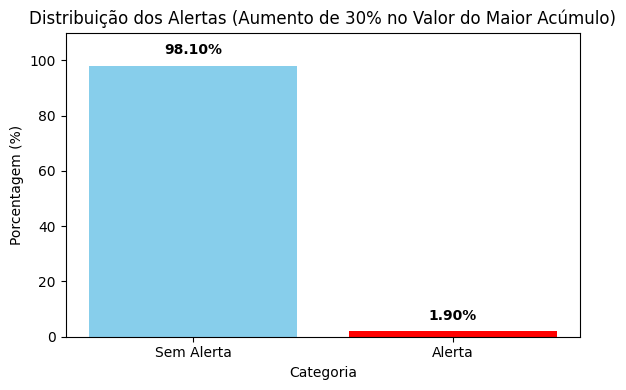

In [517]:
import pandas as pd
import matplotlib.pyplot as plt

# Contagem dos valores em 'amountGreaterAccumulationAlert' com porcentagem
value_counts = data2['amountGreaterAccumulationAlert'].value_counts(normalize=True) * 100

# Definindo as cores: vermelho para 'Alerta' e azul claro para 'Sem Alerta'
colors = ['red' if value else 'skyblue' for value in value_counts.index]

# Ajustando o tamanho do gr√°fico
plt.figure(figsize=(6, 4))  # Dimens√£o reduzida: 6 polegadas de largura por 4 de altura

# Plotando o gr√°fico de barras
plt.bar(value_counts.index.map({True: 'Alerta', False: 'Sem Alerta'}), value_counts.values, color=colors)

# Inserindo os valores de porcentagem acima das barras
for i, value in enumerate(value_counts.values):
    plt.text(i, value + 3, f'{value:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Configura√ß√µes do gr√°fico
plt.title('Distribui√ß√£o dos Alertas (Aumento de 30% no Valor do Maior Ac√∫mulo)')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Categoria')
plt.ylim(0, 110)  # Aumentando o limite superior do eixo Y para dar espa√ßo ao texto
plt.tight_layout()  # Ajustar automaticamente os elementos do gr√°fico
plt.show()

In [518]:
# Drop the moving average column
data2 = data2.drop(columns=['3_months_avg'])
data2 = data2.drop(columns=['amountGreaterAccumulation'])

**Crescimento na Quantidade de Associadas no Maior Ac√∫mulo**



In [519]:
# Calcula a m√©dia m√≥vel de 3 meses para cada cliente
data2['3_months_avg'] = (
    data2.groupby('customerID')['quantityGreaterAccumulation']
    .apply(lambda x: x.rolling(window=3, min_periods=1).mean())
    .reset_index(level=0, drop=True)  # Reset o √≠ndice para corresponder ao DataFrame original.
)

In [520]:
# Verifica se houve um aumento de 30% em compara√ß√£o com a m√©dia m√≥vel de 3 meses
data2['quantityGreaterAccumulationAlert'] = (
    (data2['quantityGreaterAccumulation'] > 1.3 * data2['3_months_avg']) &
    (data2['3_months_avg'] > 0)  # Para evitar a divis√£o por zero
)

In [521]:
# Drop the moving average column
data2 = data2.drop(columns=['3_months_avg'])
data2 = data2.drop(columns=['quantityGreaterAccumulation'])

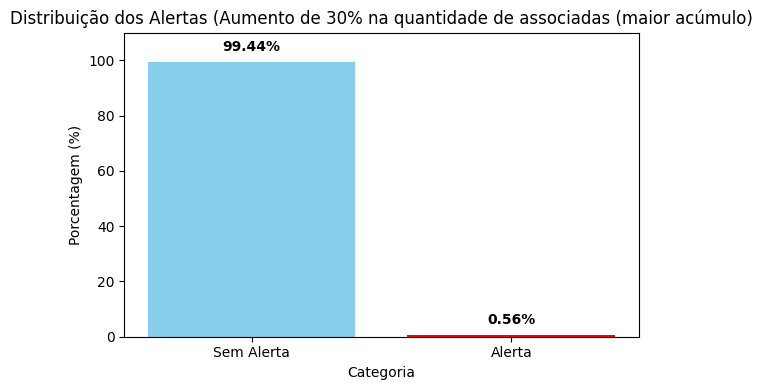

In [522]:
import pandas as pd
import matplotlib.pyplot as plt

# Contagem dos valores em 'quantityGreaterAccumulationAlert' com porcentagem
value_counts = data2['quantityGreaterAccumulationAlert'].value_counts(normalize=True) * 100

# Definindo as cores: vermelho para 'Alerta' e azul claro para 'Sem Alerta'
colors = ['red' if value else 'skyblue' for value in value_counts.index]

# Ajustando o tamanho do gr√°fico
plt.figure(figsize=(6, 4))  # Dimens√£o reduzida: 6 polegadas de largura por 4 de altura

# Plotando o gr√°fico de barras
plt.bar(value_counts.index.map({True: 'Alerta', False: 'Sem Alerta'}), value_counts.values, color=colors)

# Inserindo os valores de porcentagem acima das barras
for i, value in enumerate(value_counts.values):
    plt.text(i, value + 3, f'{value:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Configura√ß√µes do gr√°fico
plt.title('Distribui√ß√£o dos Alertas (Aumento de 30% na quantidade de associadas (maior ac√∫mulo)')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Categoria')
plt.ylim(0, 110)  # Aumentando o limite superior do eixo Y para dar espa√ßo ao texto
plt.tight_layout()  # Ajustar automaticamente os elementos do gr√°fico
plt.show()

**Crescimento At√≠pico no Valor do D√©bito Total**

In [523]:
# Calcula a m√©dia m√≥vel de 3 meses para cada cliente
data2['3_months_avg'] = (
    data2.groupby('customerID')['amountDebit']
    .apply(lambda x: x.rolling(window=3, min_periods=1).mean())
    .reset_index(level=0, drop=True)  # Reset o √≠ndice para corresponder ao DataFrame original.
)

In [524]:
# Verifica se houve um aumento de 30% em compara√ß√£o com a m√©dia m√≥vel de 3 meses
data2['amountDebitAlert'] = (
    (data2['amountDebit'] > 1.3 * data2['3_months_avg']) &
    (data2['3_months_avg'] > 0)  # Para evitar a divis√£o por zero
)

In [525]:
# Drop the moving average column
data2 = data2.drop(columns=['3_months_avg'])
data2 = data2.drop(columns=['amountDebit'])

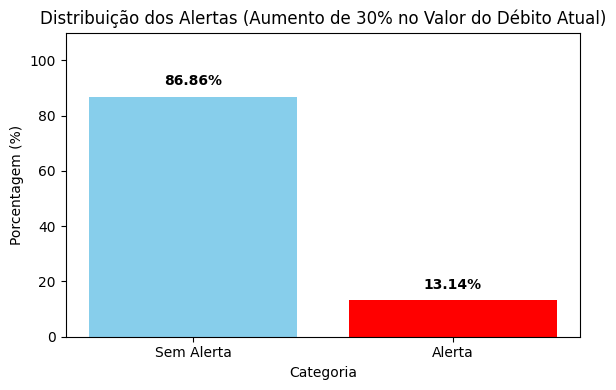

In [526]:
import pandas as pd
import matplotlib.pyplot as plt

# Contagem dos valores em 'amountDebitAlert' com porcentagem
value_counts = data2['amountDebitAlert'].value_counts(normalize=True) * 100

# Definindo as cores: vermelho para 'Alerta' e azul claro para 'Sem Alerta'
colors = ['red' if value else 'skyblue' for value in value_counts.index]

# Ajustando o tamanho do gr√°fico
plt.figure(figsize=(6, 4))  # Dimens√£o reduzida: 6 polegadas de largura por 4 de altura

# Plotando o gr√°fico de barras
plt.bar(value_counts.index.map({True: 'Alerta', False: 'Sem Alerta'}), value_counts.values, color=colors)

# Inserindo os valores de porcentagem acima das barras
for i, value in enumerate(value_counts.values):
    plt.text(i, value + 3, f'{value:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Configura√ß√µes do gr√°fico
plt.title('Distribui√ß√£o dos Alertas (Aumento de 30% no Valor do D√©bito Atual)')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Categoria')
plt.ylim(0, 110)  # Aumentando o limite superior do eixo Y para dar espa√ßo ao texto
plt.tight_layout()

**Crescimento na Quantidade de Associadas no Valor do D√©bito Total**


In [527]:
# Calcula a m√©dia m√≥vel de 3 meses para cada cliente
data2['3_months_avg'] = (
    data2.groupby('customerID')['quantityDebit']
    .apply(lambda x: x.rolling(window=3, min_periods=1).mean())
    .reset_index(level=0, drop=True)  # Reset o √≠ndice para corresponder ao DataFrame original.
)

In [528]:
# Verifica se houve um aumento de 30% em compara√ß√£o com a m√©dia m√≥vel de 3 meses
data2['quantityDebitAlert'] = (
    (data2['quantityDebit'] > 1.3 * data2['3_months_avg']) &
    (data2['3_months_avg'] > 0)  # Para evitar a divis√£o por zero
)

In [529]:
# Drop the moving average column
data2 = data2.drop(columns=['3_months_avg'])
data2 = data2.drop(columns=['quantityDebit'])

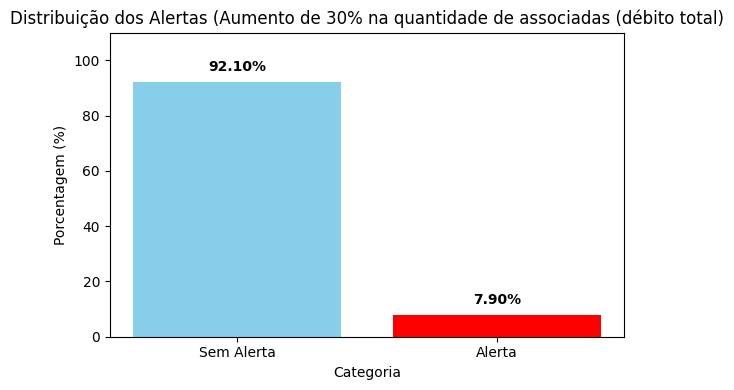

In [530]:
import pandas as pd
import matplotlib.pyplot as plt

# Contagem dos valores em 'quantityDebitAlert' com porcentagem
value_counts = data2['quantityDebitAlert'].value_counts(normalize=True) * 100

# Definindo as cores: vermelho para 'Alerta' e azul claro para 'Sem Alerta'
colors = ['red' if value else 'skyblue' for value in value_counts.index]

# Ajustando o tamanho do gr√°fico
plt.figure(figsize=(6, 4))  # Dimens√£o reduzida: 6 polegadas de largura por 4 de altura

# Plotando o gr√°fico de barras
plt.bar(value_counts.index.map({True: 'Alerta', False: 'Sem Alerta'}), value_counts.values, color=colors)

# Inserindo os valores de porcentagem acima das barras
for i, value in enumerate(value_counts.values):
    plt.text(i, value + 3, f'{value:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Configura√ß√µes do gr√°fico
plt.title('Distribui√ß√£o dos Alertas (Aumento de 30% na quantidade de associadas (d√©bito total)')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Categoria')
plt.ylim(0, 110)  # Aumentando o limite superior do eixo Y para dar espa√ßo ao texto
plt.tight_layout()  # Ajustar automaticamente os elementos do gr√°fico
plt.show()

In [531]:
data2.to_csv("/content/drive/MyDrive/fraudes-financeiras-isolation-forest/consolidatedData.csv", index=False, encoding='utf-8')  # index=False para n√£o salvar o √≠ndice
print("Arquivo salvo como 'consolidatedData.csv'")

Arquivo salvo como 'consolidatedData.csv'


# **Isolation Forest**

In [532]:
# Importando bibliotecas necess√°rias
import pandas as pd
import numpy as np

In [533]:
df = pd.read_csv('/content/drive/MyDrive/fraudes-financeiras-isolation-forest/consolidatedData.csv');

In [534]:
df.head(10)

customerID  updated rating statusActive  addressChanged  cnaeChanged  nameChanged riskFoundation  isNewFoundation  registrationAlert  queriesIncreaseAlert  isLastPurchase  amountGreaterAccumulationAlert  quantityGreaterAccumulationAlert  amountDebitAlert  quantityDebitAlert
0   382108      2       d      True          True           False        False        Low            False            False              False                 False           False                           False                             False             False             
1   382108      3       c      True         False           False        False        Low            False            False              False                  True           False                           False                             False             False             
2   382108      5       d      True         False            True        False        Low            False            False              False                 False           False                           False                              True              True             
3   382108      6       c      True         False           False        False        Low            False            False              False                 False           False                           False                             False             False             
4   382108      7       c      True         False           False        False        Low            False            False               True                 False           False                           False                             False             False             
5   382108      8       c      True         False           False        False        Low            False            False              False                 False           False                           False                             False             False             
6   382108     10       d      True         False           False        False        Low            False            False              False                 False           False                           False                             False             False             
7   382108     11       c      True         False           False        False        Low            False            False               True                 False           False                           False                             False             False             
8   382108     12       c      True          True           False        False        Low            False            False              False                 False           False                           False                             False             False             
9  3000125      2       e       NaN          True           False        False        Low            False            False              False                 False           False                           False                             False             False

In [535]:
df = df.dropna()

In [536]:
df.head()

customerID  updated rating statusActive  addressChanged  cnaeChanged  nameChanged riskFoundation  isNewFoundation  registrationAlert  queriesIncreaseAlert  isLastPurchase  amountGreaterAccumulationAlert  quantityGreaterAccumulationAlert  amountDebitAlert  quantityDebitAlert
0  382108      2        d      True          True           False        False        Low            False            False              False                 False           False                           False                             False             False             
1  382108      3        c      True         False           False        False        Low            False            False              False                  True           False                           False                             False             False             
2  382108      5        d      True         False            True        False        Low            False            False              False                 False           False                           False                              True              True             
3  382108      6        c      True         False           False        False        Low            False            False              False                 False           False                           False                             False             False             
4  382108      7        c      True         False           False        False        Low            False            False               True                 False           False                           False                             False             False

In [537]:
df.shape

(388066, 16)

In [538]:
# Garantir que customerID est√° como string de 14 d√≠gitos
df['customerID'] = df['customerID'].astype(str).str.zfill(14)

In [539]:
#Executar o filtro de acordo com o Rating (M√©dio e Alto Risco) C, D e E
quantidade = df.shape[0]
print(f"Quantidade de registros: {quantidade}")

Quantidade de registros: 388066


In [540]:
#Executar o filtro de acordo com o Rating (M√©dio e Alto Risco) C, D e E
df = df[df['rating'].isin(['c', 'd', 'e'])]

In [541]:
#total filtrado
quantidade = df.shape[0]
print(f"Quantidade de registros: {quantidade}")

Quantidade de registros: 41162


In [542]:
# Aplicar One-Hot Encoding em m√∫ltiplas colunas
columns_to_encode = [
    'addressChanged',
    'statusActive',
    'cnaeChanged',
    'nameChanged',
    'riskFoundation',
    'registrationAlert',
    'queriesIncreaseAlert',
    'quantityGreaterAccumulationAlert',
    'quantityDebitAlert',
    'amountDebitAlert',
    'amountGreaterAccumulationAlert'
    ]
df = pd.get_dummies(df, columns=columns_to_encode)

In [543]:
df.head()

customerID       updated rating  isNewFoundation  isLastPurchase  addressChanged_False  addressChanged_True  statusActive_False  statusActive_True  cnaeChanged_False  cnaeChanged_True  nameChanged_False  nameChanged_True  riskFoundation_Low  registrationAlert_False  queriesIncreaseAlert_False  queriesIncreaseAlert_True  quantityGreaterAccumulationAlert_False  quantityGreaterAccumulationAlert_True  quantityDebitAlert_False  quantityDebitAlert_True  amountDebitAlert_False  amountDebitAlert_True  amountGreaterAccumulationAlert_False  amountGreaterAccumulationAlert_True
0  00000000382108  2        d      False            False           False                  True                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                   True                     False                     True                   False                  True                                  False                              
1  00000000382108  3        c      False             True            True                 False                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                   True                     False                     True                   False                  True                                  False                              
2  00000000382108  5        d      False            False            True                 False                False               True               False               True             True               False             True                True                      True                       False                      True                                    False                                  False                      True                    False                    True                  True                                  False                              
3  00000000382108  6        c      False            False            True                 False                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                   True                     False                     True                   False                  True                                  False                              
4  00000000382108  7        c      False            False            True                 False                False               True                True              False             True               False             True                True                     False                        True                      True                                    False                                   True                     False                     True                   False                  True                                  False

In [544]:
filtro_de = df[df['rating'].isin(['d', 'e'])]
cnpjs_unicos = filtro_de['customerID'].unique()
quantidade_cnpjs_unicos = len(cnpjs_unicos)
print(f"Quantidade de CNPJs √∫nicos com rating 'd' ou 'e': {quantidade_cnpjs_unicos}")

Quantidade de CNPJs √∫nicos com rating 'd' ou 'e': 4736


In [545]:
print(cnpjs_unicos[:30])


['00000000382108' '00004298000108' '00005929000103' '00012810000168'
 '00013579000127' '00015305000177' '00024050000109' '00028432000100'
 '00028822000180' '00056217000113' '00056685000198' '00058744000167'
 '00061315000149' '00063960000109' '00065644000168' '00068784000190'
 '00069308000193' '00070221000136' '00071322000121' '00075961000165'
 '00076982000103' '00082801000143' '00094927000138' '00095051000144'
 '00095131000108' '00097646000139' '00099334000164' '00099743000160'
 '00102025000104' '00108806000106']


In [546]:
#Filtrar as anomalias e indimplencias reais para n√£o treinar no modelo

# Lista de anomalias(golpes) reais
anomalia = ['00109498000125', '00827368000128', '17496140000103', '41439232000128', '30911251000199', '08002972000127']

# Lista de inadimplencias(normais) reais
normal = ['09242923000124', '97551360000113', ' 97550909000155', '00005929000103', '00013579000127', '97538546000132', ' 00164583000196', '00144585000113', '00099334000164']

anomalias_reais = df[df['customerID'].isin(anomalia)]
normal_reais = df[df['customerID'].isin(normal)]

In [547]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest


In [548]:
X = df.drop(columns=['customerID', 'updated', 'rating'])

In [549]:
from sklearn.ensemble import IsolationForest

# Treinar o Isolation Forest com a taxa real de anomalias
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X)

IsolationForest(contamination=0.05, random_state=42)

In [550]:
# Predi√ß√µes
y_pred = model.predict(X)

In [551]:
df['y_pred'] = y_pred

In [552]:
df.head(5)

customerID       updated rating  isNewFoundation  isLastPurchase  addressChanged_False  addressChanged_True  statusActive_False  statusActive_True  cnaeChanged_False  cnaeChanged_True  nameChanged_False  nameChanged_True  riskFoundation_Low  registrationAlert_False  queriesIncreaseAlert_False  queriesIncreaseAlert_True  quantityGreaterAccumulationAlert_False  quantityGreaterAccumulationAlert_True  quantityDebitAlert_False  quantityDebitAlert_True  amountDebitAlert_False  amountDebitAlert_True  amountGreaterAccumulationAlert_False  amountGreaterAccumulationAlert_True  y_pred
0  00000000382108  2        d      False            False           False                  True                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                   True                     False                     True                   False                  True                                  False                                1     
1  00000000382108  3        c      False             True            True                 False                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                   True                     False                     True                   False                  True                                  False                                1     
2  00000000382108  5        d      False            False            True                 False                False               True               False               True             True               False             True                True                      True                       False                      True                                    False                                  False                      True                    False                    True                  True                                  False                                1     
3  00000000382108  6        c      False            False            True                 False                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                   True                     False                     True                   False                  True                                  False                                1     
4  00000000382108  7        c      False            False            True                 False                False               True                True              False             True               False             True                True                     False                        True                      True                                    False                                   True                     False                     True                   False                  True                                  False                                1

In [553]:
print(df['y_pred'].value_counts())

y_pred
 1    39176
-1     1986
Name: count, dtype: int64


In [554]:
import numpy as np

# Percentual de anomalias detectadas
anomaly_percentage = np.mean(y_pred == -1) * 100
print(f'Anomalias detectadas: {anomaly_percentage:.2f}%')


Anomalias detectadas: 4.82%


In [555]:
anomalias_reais.head(100)

customerID       updated rating  isNewFoundation  isLastPurchase  addressChanged_False  addressChanged_True  statusActive_False  statusActive_True  cnaeChanged_False  cnaeChanged_True  nameChanged_False  nameChanged_True  riskFoundation_Low  registrationAlert_False  queriesIncreaseAlert_False  queriesIncreaseAlert_True  quantityGreaterAccumulationAlert_False  quantityGreaterAccumulationAlert_True  quantityDebitAlert_False  quantityDebitAlert_True  amountDebitAlert_False  amountDebitAlert_True  amountGreaterAccumulationAlert_False  amountGreaterAccumulationAlert_True
3038    00109498000125   8       e      False            False           False                  True                False               True               False               True             True               False             True                True                      True                       False                      True                                    False                                  True                      False                     True                   False                  False                                  True                              
28405   00827368000128   2       e      False            False           False                  True                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                  True                      False                     True                   False                   True                                 False                              
28406   00827368000128   7       c      False            False            True                 False                False               True               False               True             True               False             True                True                     False                        True                      True                                    False                                  True                      False                     True                   False                   True                                 False                              
28407   00827368000128   8       d      False            False            True                 False                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                  True                      False                     True                   False                   True                                 False                              
341264  08002972000127   6       c      False            False           False                  True                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                  True                      False                     True                   False                   True                                 False                              
341265  08002972000127   7       c      False            False            True                 False                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                  True                      False                     True                   False                   True                

In [556]:
# Adicionando a coluna y_real com valor -1
anomalias_reais.loc[:, 'y_real'] = -1


<ipython-input-556-d63662e5dd68>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalias_reais.loc[:, 'y_real'] = -1


In [557]:
# Adicionando a coluna y_real com valor 1
normal_reais.loc[:, 'y_real'] = -1


<ipython-input-557-4a84890a04aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_reais.loc[:, 'y_real'] = -1


In [558]:
df_real = pd.concat([anomalias_reais, normal_reais])

In [559]:
df_real.head(5)

customerID       updated rating  isNewFoundation  isLastPurchase  addressChanged_False  addressChanged_True  statusActive_False  statusActive_True  cnaeChanged_False  cnaeChanged_True  nameChanged_False  nameChanged_True  riskFoundation_Low  registrationAlert_False  queriesIncreaseAlert_False  queriesIncreaseAlert_True  quantityGreaterAccumulationAlert_False  quantityGreaterAccumulationAlert_True  quantityDebitAlert_False  quantityDebitAlert_True  amountDebitAlert_False  amountDebitAlert_True  amountGreaterAccumulationAlert_False  amountGreaterAccumulationAlert_True  y_real
3038    00109498000125  8        e      False            False           False                  True                False               True               False               True             True               False             True                True                      True                       False                      True                                    False                                  True                      False                    True                    False                  False                                  True                               -1     
28405   00827368000128  2        e      False            False           False                  True                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                  True                      False                    True                    False                   True                                 False                               -1     
28406   00827368000128  7        c      False            False            True                 False                False               True               False               True             True               False             True                True                     False                        True                      True                                    False                                  True                      False                    True                    False                   True                                 False                               -1     
28407   00827368000128  8        d      False            False            True                 False                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                  True                      False                    True                    False                   True                                 False                               -1     
341264  08002972000127  6        c      False            False           False                  True                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                  True                      False                    True                    False                   True                                 False                               -1

In [560]:
X_real = df_real.drop(columns=['customerID', 'updated', 'rating', 'y_real'])

In [561]:
# Predi√ß√µes do modelo com casos reais
df_real['y_pred'] = model.predict(X_real)

In [562]:
print(df_real['y_pred'].value_counts())

y_pred
 1    29
-1     1
Name: count, dtype: int64


In [563]:
df_real.head(100)

customerID       updated rating  isNewFoundation  isLastPurchase  addressChanged_False  addressChanged_True  statusActive_False  statusActive_True  cnaeChanged_False  cnaeChanged_True  nameChanged_False  nameChanged_True  riskFoundation_Low  registrationAlert_False  queriesIncreaseAlert_False  queriesIncreaseAlert_True  quantityGreaterAccumulationAlert_False  quantityGreaterAccumulationAlert_True  quantityDebitAlert_False  quantityDebitAlert_True  amountDebitAlert_False  amountDebitAlert_True  amountGreaterAccumulationAlert_False  amountGreaterAccumulationAlert_True  y_real  y_pred
3038    00109498000125   8       e      False            False           False                  True                False               True               False               True             True               False             True                True                      True                       False                      True                                    False                                   True                     False                     True                   False                  False                                  True                               -1      -1     
28405   00827368000128   2       e      False            False           False                  True                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                   True                     False                     True                   False                   True                                 False                               -1       1     
28406   00827368000128   7       c      False            False            True                 False                False               True               False               True             True               False             True                True                     False                        True                      True                                    False                                   True                     False                     True                   False                   True                                 False                               -1       1     
28407   00827368000128   8       d      False            False            True                 False                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                   True                     False                     True                   False                   True                                 False                               -1       1     
341264  08002972000127   6       c      False            False           False                  True                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                   True                     False                     True                   False                   True                                 False                               -1       1     
341265  08002972000127   7       c      False            False            True                 False                False               True                True              False             True               False             True                True                      True                       False                      True                                    False                                   True                  

In [564]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Suponha que y_real e y_pred estejam definidos
# y_pred vem do modelo IsolationForest (valores: -1 para anomalias, 1 para normais)

# Exemplo de binariza√ß√£o, se necess√°rio (opcional):
# y_real = [1 se normal, -1 se anomalia]  # Deve estar nesse formato

# M√©tricas individuais
acc = accuracy_score(df_real['y_real'], df_real['y_pred'])
prec = precision_score(df_real['y_real'], df_real['y_pred'], pos_label=-1)
rec = recall_score(df_real['y_real'], df_real['y_pred'], pos_label=-1)
f1 = f1_score(df_real['y_real'], df_real['y_pred'], pos_label=-1)
cm = confusion_matrix(df_real['y_real'], df_real['y_pred'])

# Exibe relat√≥rio completo
report = classification_report(df_real['y_real'], df_real['y_pred'], target_names=["Normal", "Anomalia"], labels=[1, -1])

print("üîé M√©tricas de Avalia√ß√£o do Isolation Forest")
print(f"Acur√°cia     : {acc:.4f}")
print(f"Precis√£o     : {prec:.4f}")
print(f"Recall       : {rec:.4f}")
print(f"F1-score     : {f1:.4f}")
print("\nüìä Matriz de Confus√£o:")
print(cm)
print("\nüìÑ Relat√≥rio de Classifica√ß√£o:")
print(report)


üîé M√©tricas de Avalia√ß√£o do Isolation Forest
Acur√°cia     : 0.0333
Precis√£o     : 1.0000
Recall       : 0.0333
F1-score     : 0.0645

üìä Matriz de Confus√£o:
[[ 1 29]
 [ 0  0]]

üìÑ Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         0
    Anomalia       1.00      0.03      0.06        30

    accuracy                           0.03        30
   macro avg       0.50      0.02      0.03        30
weighted avg       1.00      0.03      0.06        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


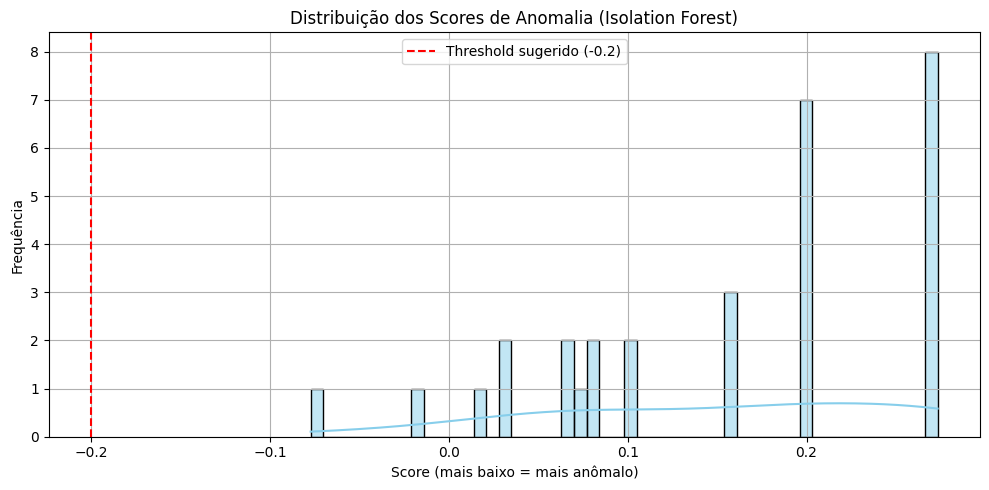

In [565]:
#Escolher o threshold
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import IsolationForest

# 1. Treinar o modelo
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X_real)  # ou X_real se for em todo o conjunto

# 2. Obter os scores
scores = model.decision_function(X_real)  # quanto menor, mais an√¥malo
df_real['score'] = scores

# 3. Plotar distribui√ß√£o
plt.figure(figsize=(10, 5))
sns.histplot(scores, bins=50, kde=True, color="skyblue")
plt.axvline(x=-0.2, color='red', linestyle='--', label='Threshold sugerido (-0.2)')
plt.title("Distribui√ß√£o dos Scores de Anomalia (Isolation Forest)")
plt.xlabel("Score (mais baixo = mais an√¥malo)")
plt.ylabel("Frequ√™ncia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [566]:
##df_real['y_pred_custom'] = [-1 if s < -0.1 else 1 for s in df_real['score']]
y_pred_custom = np.where(df_real['score'] < -0., -1, 1)
df_real['y_pred_custom'] = y_pred_custom

In [567]:
from sklearn.metrics import f1_score

best_f1 = 0
best_thresh = None

for t in np.linspace(min(df_real['score']), max(df_real['score']), 100):
    y_pred = np.where(df_real['score'] < t, -1, 1)
    f1 = f1_score(y_pred_custom, y_pred, pos_label=-1)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Melhor limiar: {best_thresh:.4f}, F1-score: {best_f1:.4f}")

Melhor limiar: -0.0135, F1-score: 1.0000


In [568]:
threshold = 0.2450
y_pred_custom = np.where(df_real['score'] < threshold, -1, 1)

In [569]:
df_real['y_pred_custom'] = y_pred_custom


In [570]:
#Avaliar as m√©tricas com y_pred_custom
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_true = df_real['y_real']
y_pred = df_real['y_pred_custom']

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, pos_label=-1)
rec = recall_score(y_true, y_pred, pos_label=-1)
f1 = f1_score(y_true, y_pred, pos_label=-1)
cm = confusion_matrix(y_true, y_pred)

print("üîÅ Avalia√ß√£o ap√≥s threshold personalizado")
print(f"Acur√°cia     : {acc:.4f}")
print(f"Precis√£o     : {prec:.4f}")
print(f"Recall       : {rec:.4f}")
print(f"F1-score     : {f1:.4f}")
print("\nüìÑ Relat√≥rio de Classifica√ß√£o:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomalia"], labels=[1, -1]))


üîÅ Avalia√ß√£o ap√≥s threshold personalizado
Acur√°cia     : 0.7333
Precis√£o     : 1.0000
Recall       : 0.7333
F1-score     : 0.8462

üìÑ Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         0
    Anomalia       1.00      0.73      0.85        30

    accuracy                           0.73        30
   macro avg       0.50      0.37      0.42        30
weighted avg       1.00      0.73      0.85        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


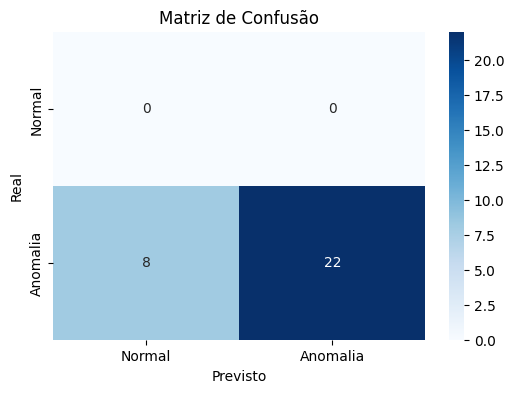

In [571]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_true: r√≥tulos reais (-1 ou 1)
# y_pred_custom: predi√ß√µes do modelo usando o threshold ajustado

cm = confusion_matrix(y_true, y_pred,labels=[1, -1])  # 1=normal, -1=anomalia

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomalia'], yticklabels=['Normal', 'Anomalia'])
plt.title("Matriz de Confus√£o")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()
